# Notebook for Testing the effect of performing Transient Iterations on LCE / CLV computation

## Imports

In [175]:
%matplotlib inline
import matplotlib as mpl
# mpl.use('TkAgg') # Use this backend for displaying plots in window
# mpl.use('Agg') # Use this backend for writing plots to file

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# plt.style.use('seaborn-talk')
mpl.rcParams['figure.figsize']    = [16, 9]
# mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['text.usetex']       = True
mpl.rcParams['font.family']       = 'serif'
mpl.rcParams['font.size']         = 22
mpl.rcParams['font.serif']        = 'Computer Modern Roman'
mpl.rcParams['lines.linewidth']   = 1.25
mpl.rcParams['lines.markersize']  = 6
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
import h5py
import sys
import os
import time as TIME
import multiprocessing as mprocs
from threading import Thread
from subprocess import Popen, PIPE
from mpl_toolkits.axes_grid1 import make_axes_locatable
from itertools import zip_longest
from matplotlib.gridspec import GridSpec
from matplotlib.pyplot import cm 
import numpy as np
from scipy.linalg import subspace_angles
np.set_printoptions(threshold=sys.maxsize)
from numba import njit, prange

## Data Space

In [176]:
N     = 512
k0    = 1
alpha = np.array([0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.49])
beta  = 0.0;
u0    = "TEST"
m_end = 100000 # (100000, 10000, 5000, 3125, 2500, 2000)
m_itr = 1  # (1, 10, 20, 32, 40, 50)
iters = m_end * m_itr
trans = 0
trans_iters = np.array([0, 10, 100, 1000, 10000, 20000, 50000])

## Folders

In [177]:
input_dir  = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS"
output_dir = "/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/Test"

## Function Definitions

In [178]:
@njit
def compute_lce(rnorm, time, iters, dof, trans):
    
    run_sum = np.zeros((dof))
    lce_py  = np.zeros((iters - trans, dof))
    
    ## Loop over time and compute lce
    for t in range(trans, iters + 1):
        
        if t > trans:
            for n in range(dof):
                run_sum[n]   += np.log(rnorm[t - 1, n])
                lce_py[t - (trans + 1), n] = run_sum[n] / (time[t] - time[trans])
                          
    return lce_py[-1, :]

@njit
def compute_dim(lce, dof):
    k = 1
    for n in range(dof):
        while np.cumsum(lce[:n]) > 0:
            k += 1
        else:
            break
            
    return k + np.cumsum(lce[:k]) / np.absolute(lce[k])

In [181]:
ans = compute_lce(rnorm, time, iters, dof, 0)
# print(ans)

[ 8.91872334e-01  6.32877576e-01  1.65901942e-01  3.94894894e-03
 -7.71432715e-02 -1.00921672e-01 -1.03385054e-01 -1.18840479e-01
 -1.35446002e-01 -1.82165668e-01 -2.18660019e-01 -2.59618854e-01
 -2.91482262e-01 -3.21084300e-01 -3.54716972e-01 -3.74896177e-01
 -4.06763341e-01 -4.31784876e-01 -4.56751850e-01 -4.85021094e-01
 -5.05566735e-01 -5.31064340e-01 -5.60447285e-01 -5.74536332e-01
 -5.96705286e-01 -6.20659547e-01 -6.43166625e-01 -6.66615894e-01
 -6.86279331e-01 -7.07162836e-01 -7.26860576e-01 -7.45602444e-01
 -7.60505065e-01 -7.88041736e-01 -8.03853919e-01 -8.23382728e-01
 -8.43962612e-01 -8.58700771e-01 -8.80333971e-01 -8.94350150e-01
 -9.14187240e-01 -9.26839223e-01 -9.49595502e-01 -9.68925175e-01
 -9.87750766e-01 -1.01299814e+00 -1.03448658e+00 -1.05211857e+00
 -1.07034460e+00 -1.09228829e+00 -1.11275137e+00 -1.13923447e+00
 -1.15775292e+00 -1.19333480e+00 -1.21845867e+00 -1.23722844e+00
 -1.26541400e+00 -1.28851745e+00 -1.31658416e+00 -1.35173309e+00
 -1.38720191e+00 -1.41397

## Loop Through Data

In [182]:
dim    = np.zeros((alpha.shape[0]))
lce    = np.zeros((int(N/2 - 1), alpha.shape[0]))

dim_py = np.zeros((trans_iters.shape[0], alpha.shape[0]))
lce_py = np.zeros((int(N/2 - 1), trans_iters.shape[0], alpha.shape[0]))

print(lce_py.shape)

(255, 7, 8)


In [183]:
for j, a in enumerate(alpha):

    ## Create filename from data
    filename = input_dir + "/RESULTS_N[{}]_k0[{}]_ALPHA[{:0.3f}]_BETA[{:0.3f}]_u0[{}]/CLVData_ITERS[{},{},{}]".format(N, k0, a, beta, u0, iters, m_end, m_itr)

    ## Check if file exists and open
    if os.path.exists(filename + "_TRANS[{}].h5".format(trans)):
        HDFfileData = h5py.File(filename + "_TRANS[{}].h5".format(trans), 'r')


    ## Read in data
    rnorm     = HDFfileData['RNorm'][:, :]
    time      = HDFfileData['Time'][:]
    lce[:, j] = HDFfileData['LCE'][-1, :]

    ## Compute needed parameters
    dof = rnorm.shape[1]

    ## Loop over transient iterations
    for i, transients in enumerate(trans_iters):

        ## print current iteration
        print(transients, a)
        
        ## Compute LCEs and Dim
        lce_py[:, i, j] = compute_lce(rnorm, time, iters, dof, transients)
        dim_py[i, j] = compute_dim(lce_py[:, i, j], dof)

    ## Compute Kaplan Yorke Dim of dataset
    dim[i] = compute_dim(lce[:, j], dof)
        
    ## Close file 
    HDFfileData.close()

OSError: Can't read data (addr overflow, addr = 4832, size = 2616, eoa = 2144)

In [186]:
# print(lce[:, 0, 0])
# print(lce_py[:, 0, 0])
# print(dim[0, 0])
# print(dim_py[0, 0])

/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/RESULTS/RESULTS_N[512]_k0[1]_ALPHA[0.000]_BETA[0.000]_u0[TEST]/CLVData_ITERS[100000,100000,1]_TRANS[0].h5


## Plot Data to Compare

/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


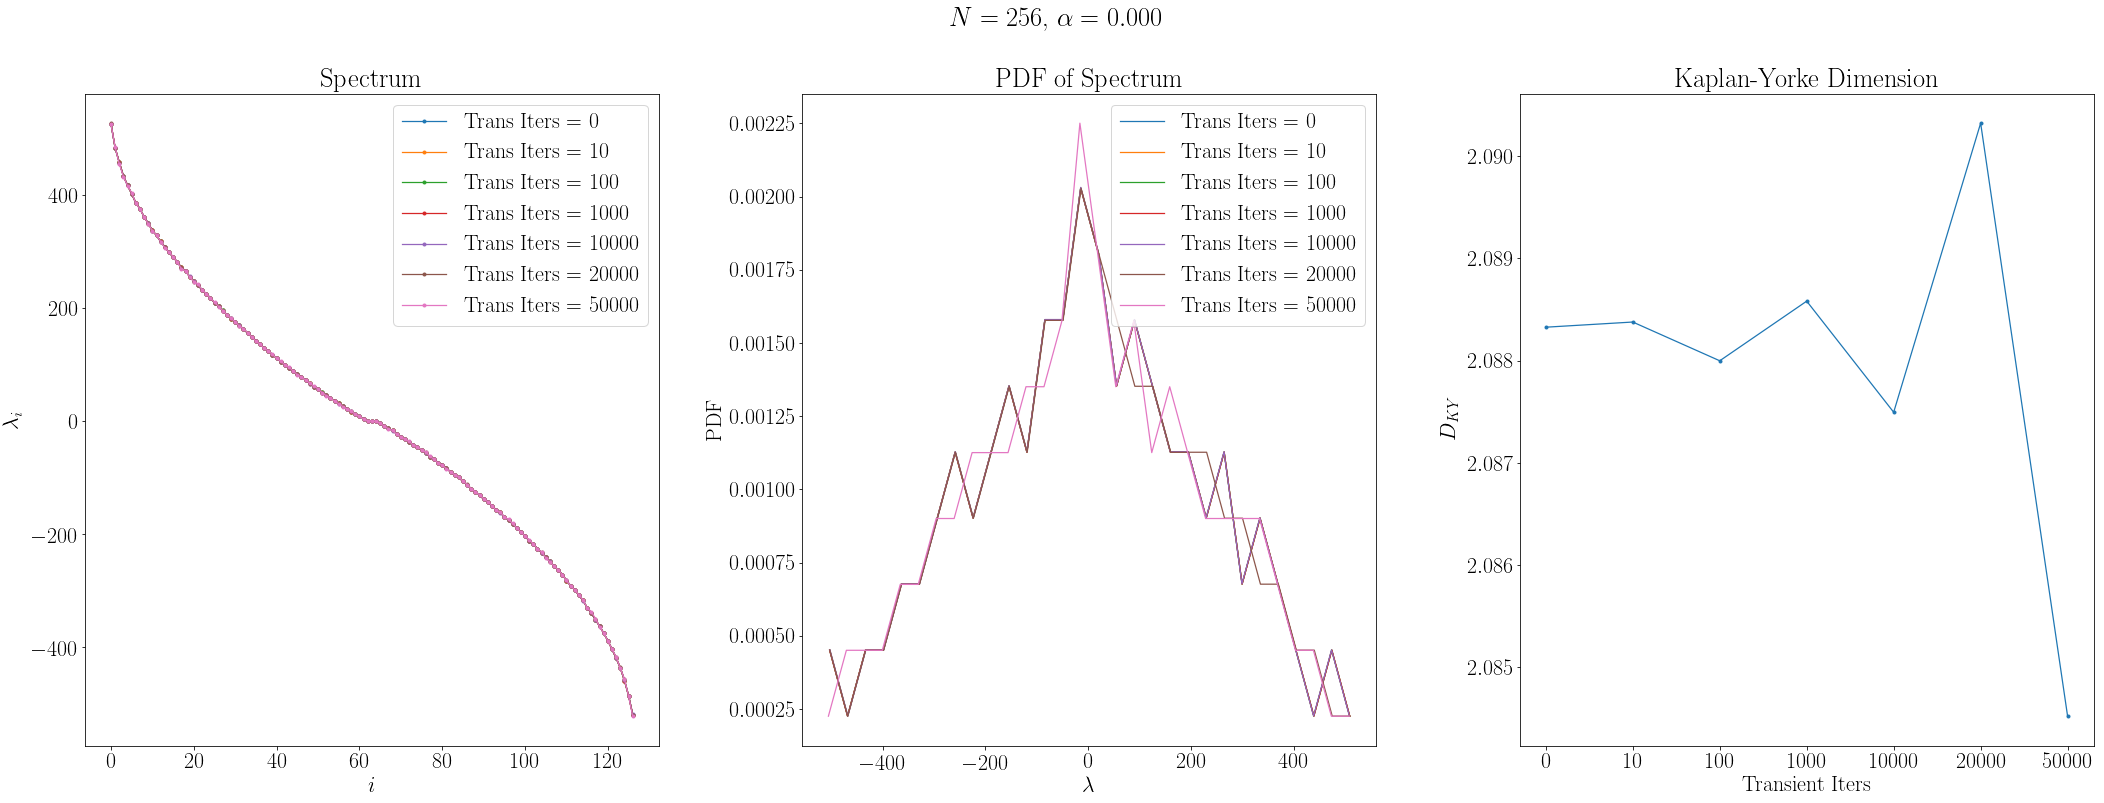

/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


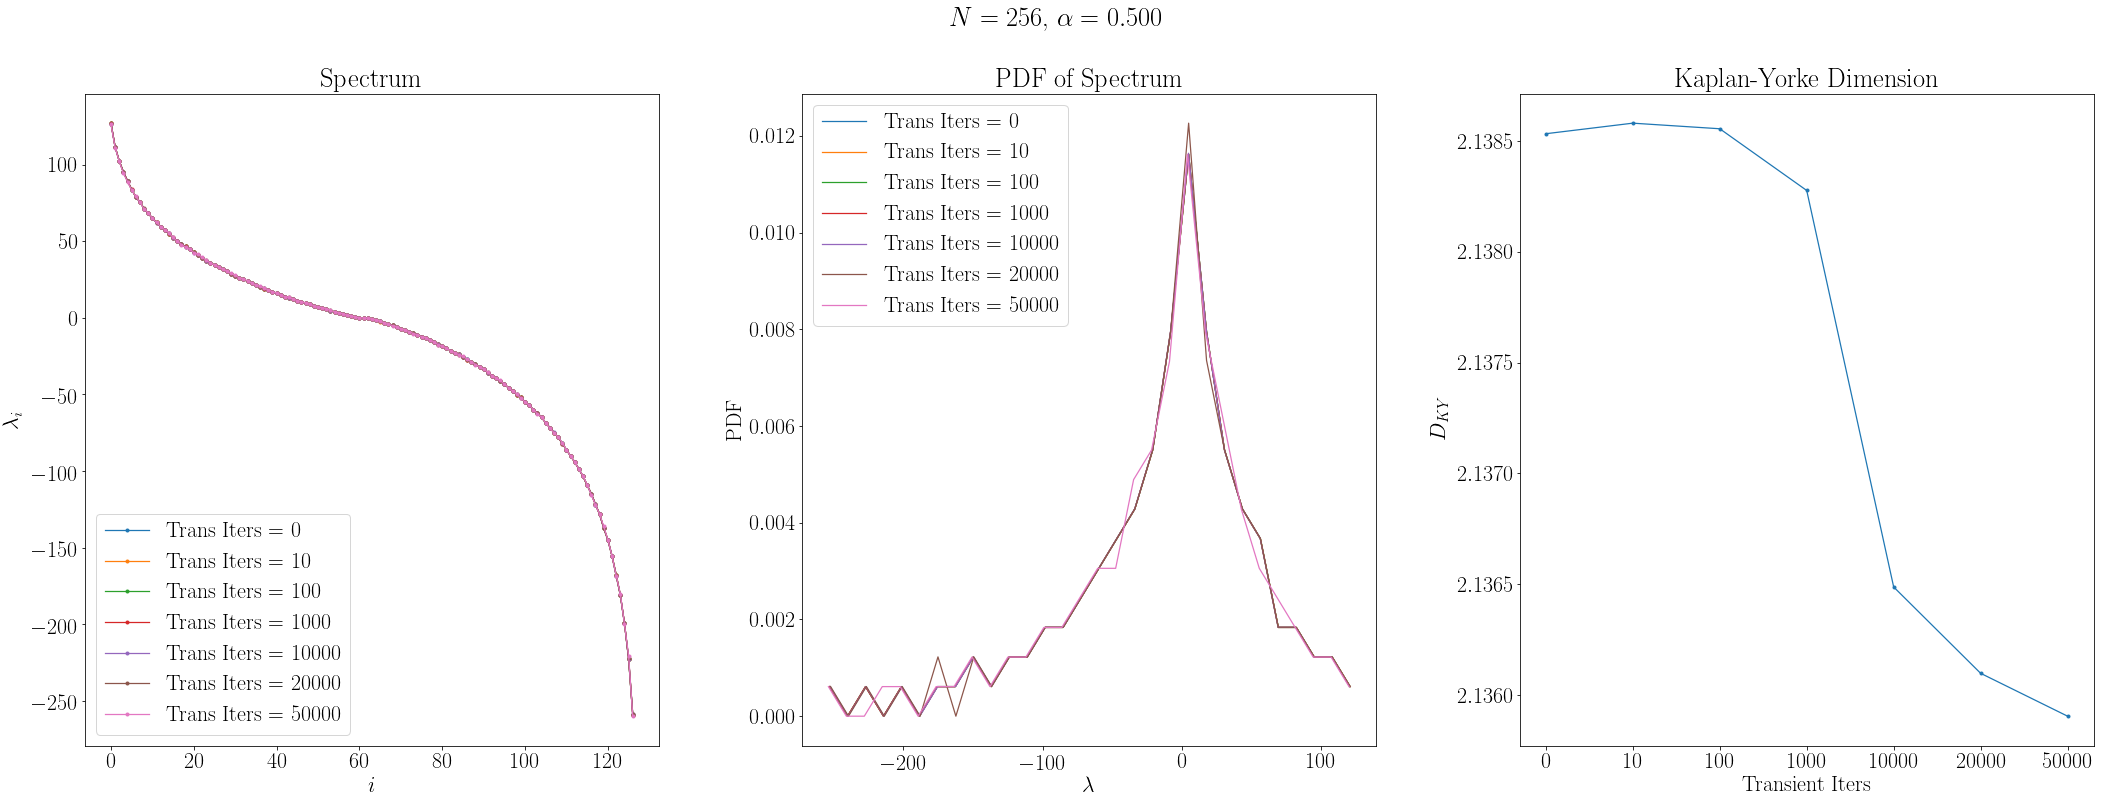

/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


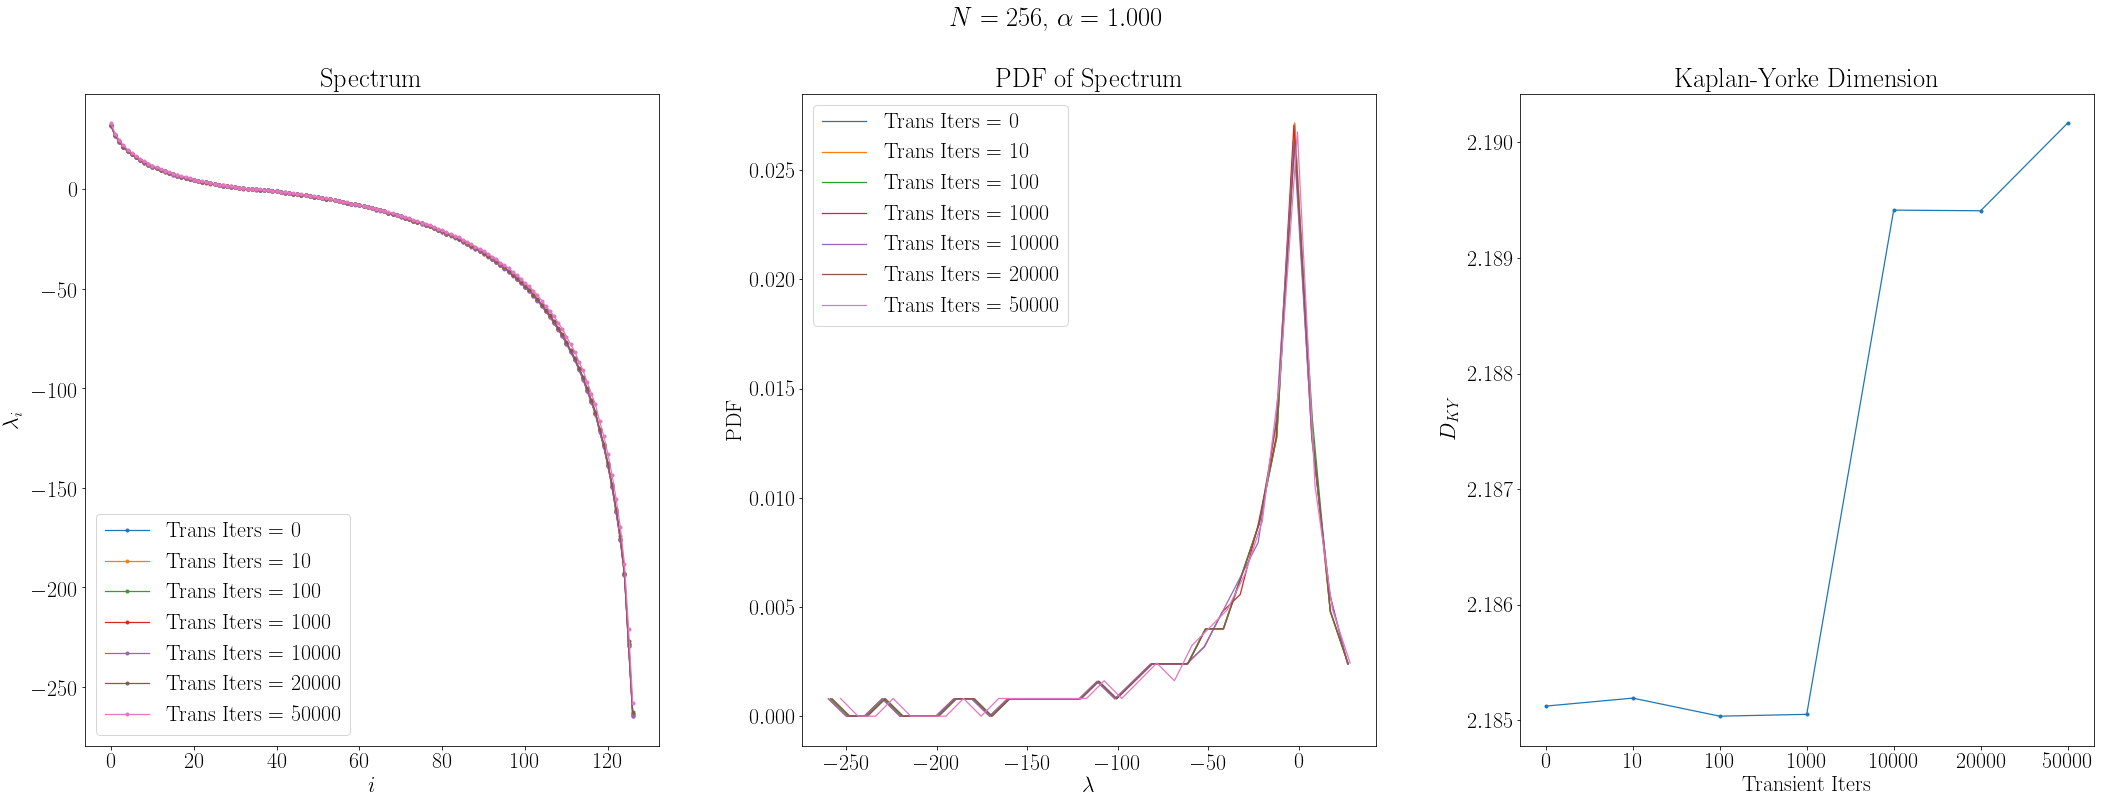

/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


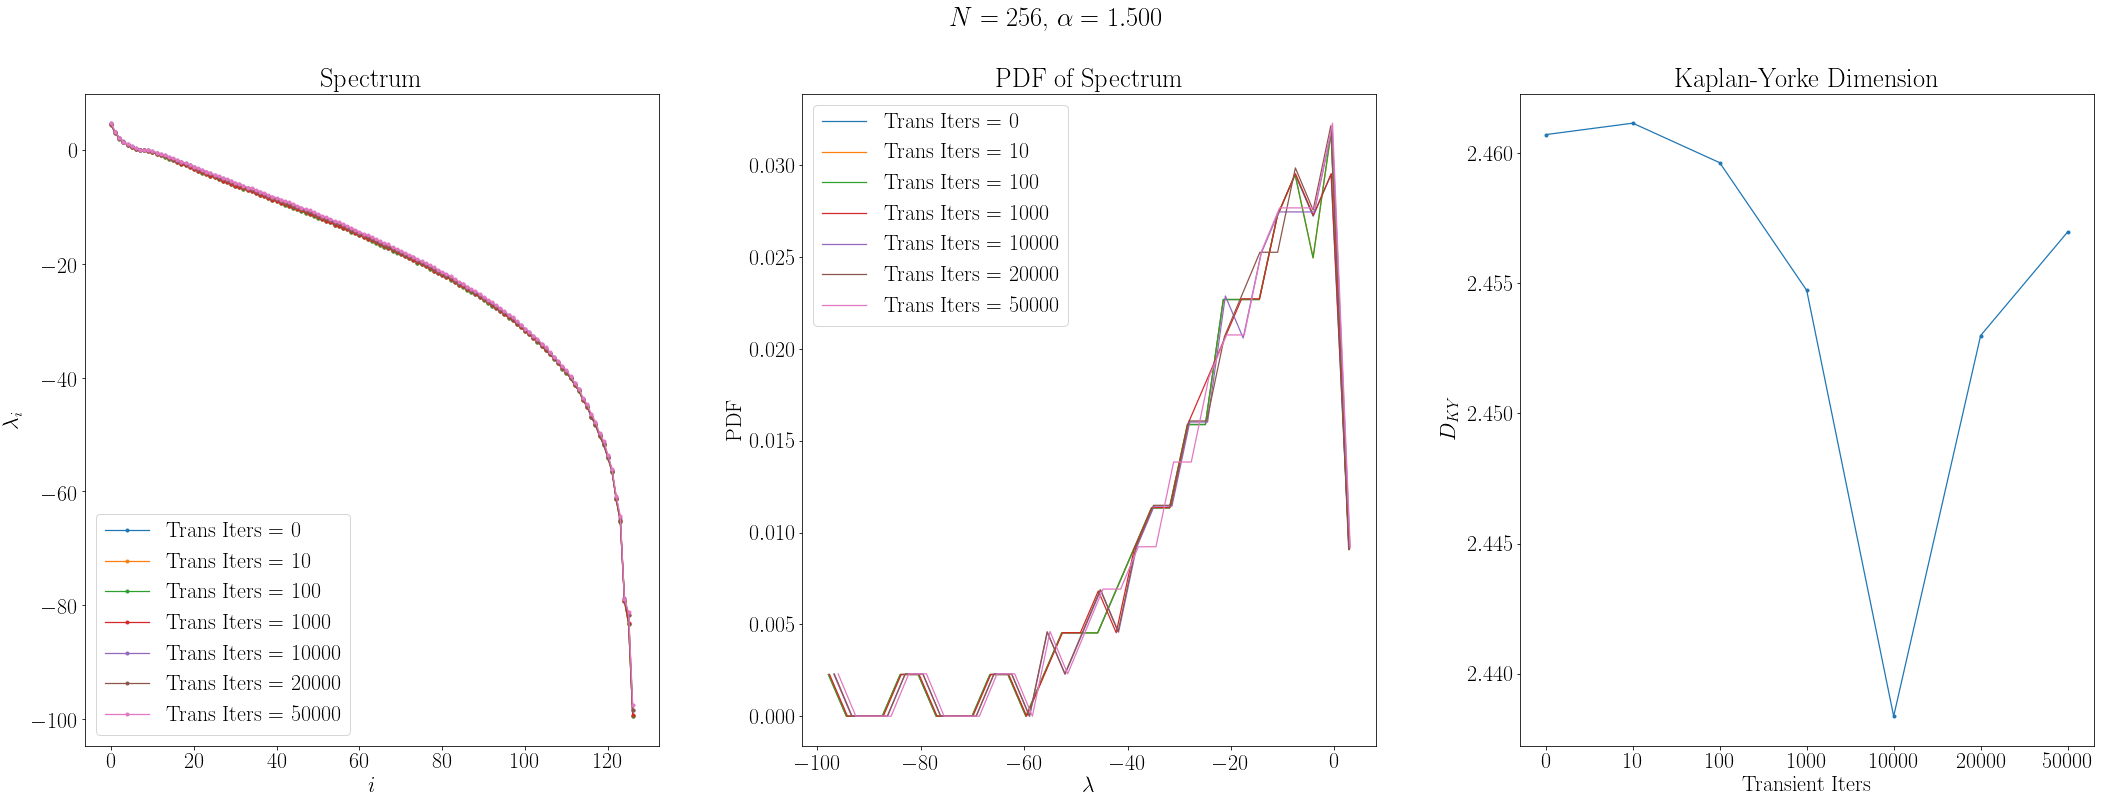

/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


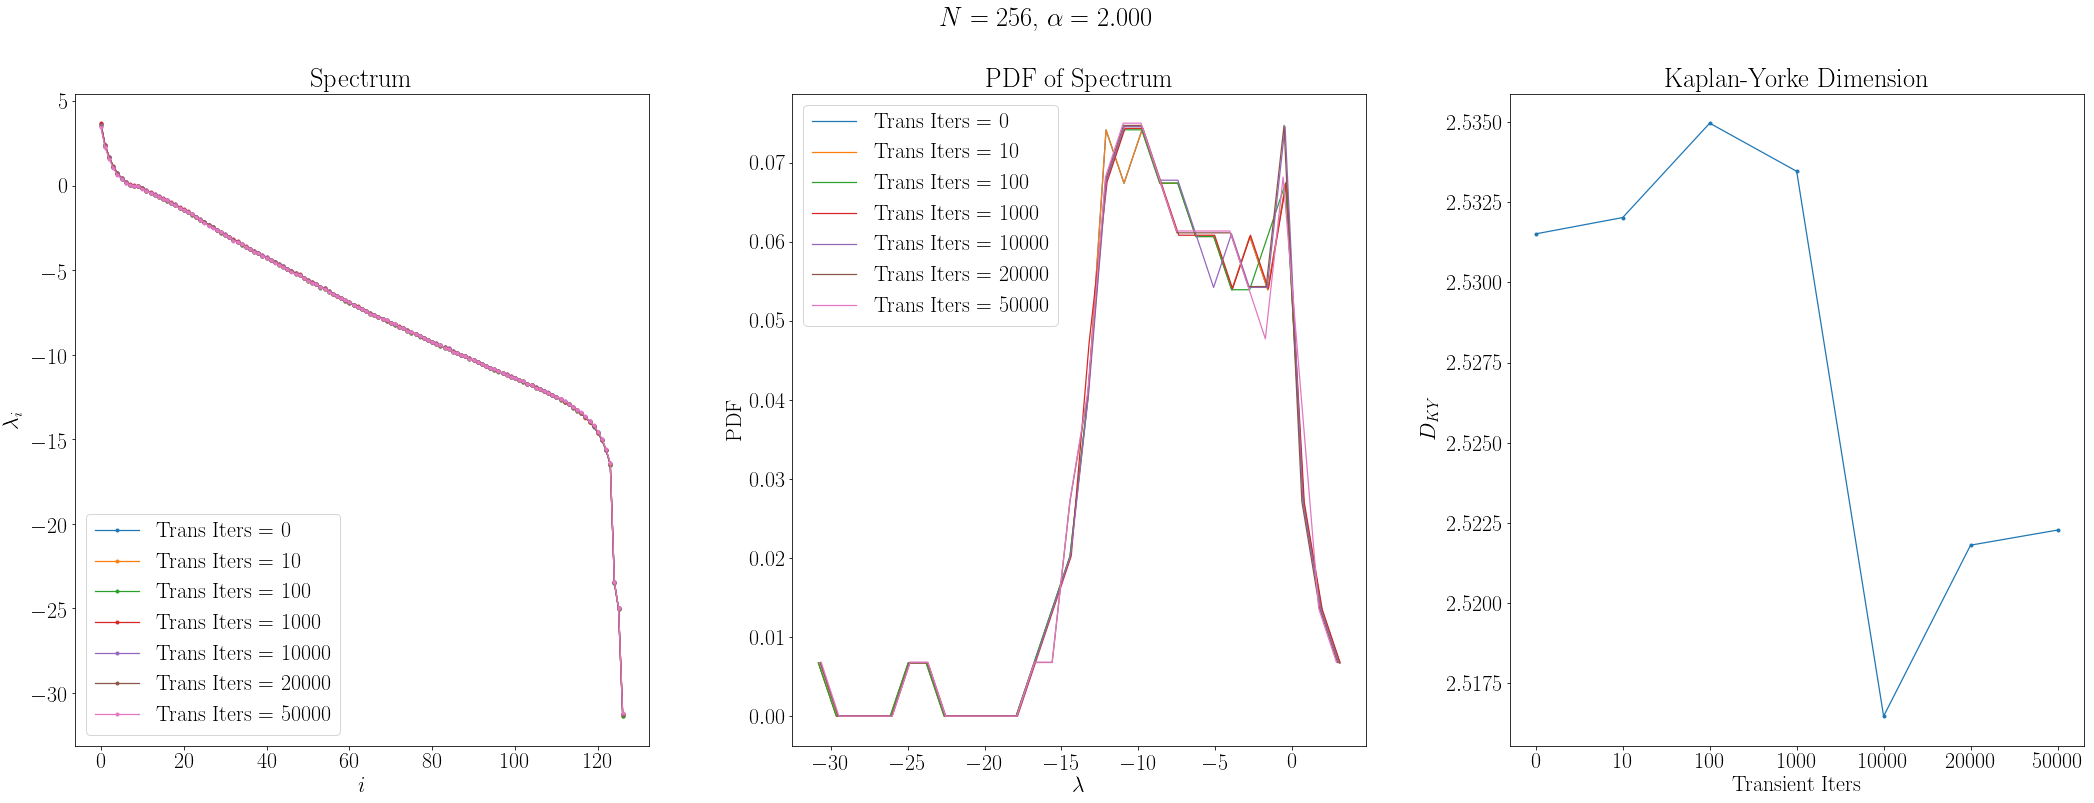

/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


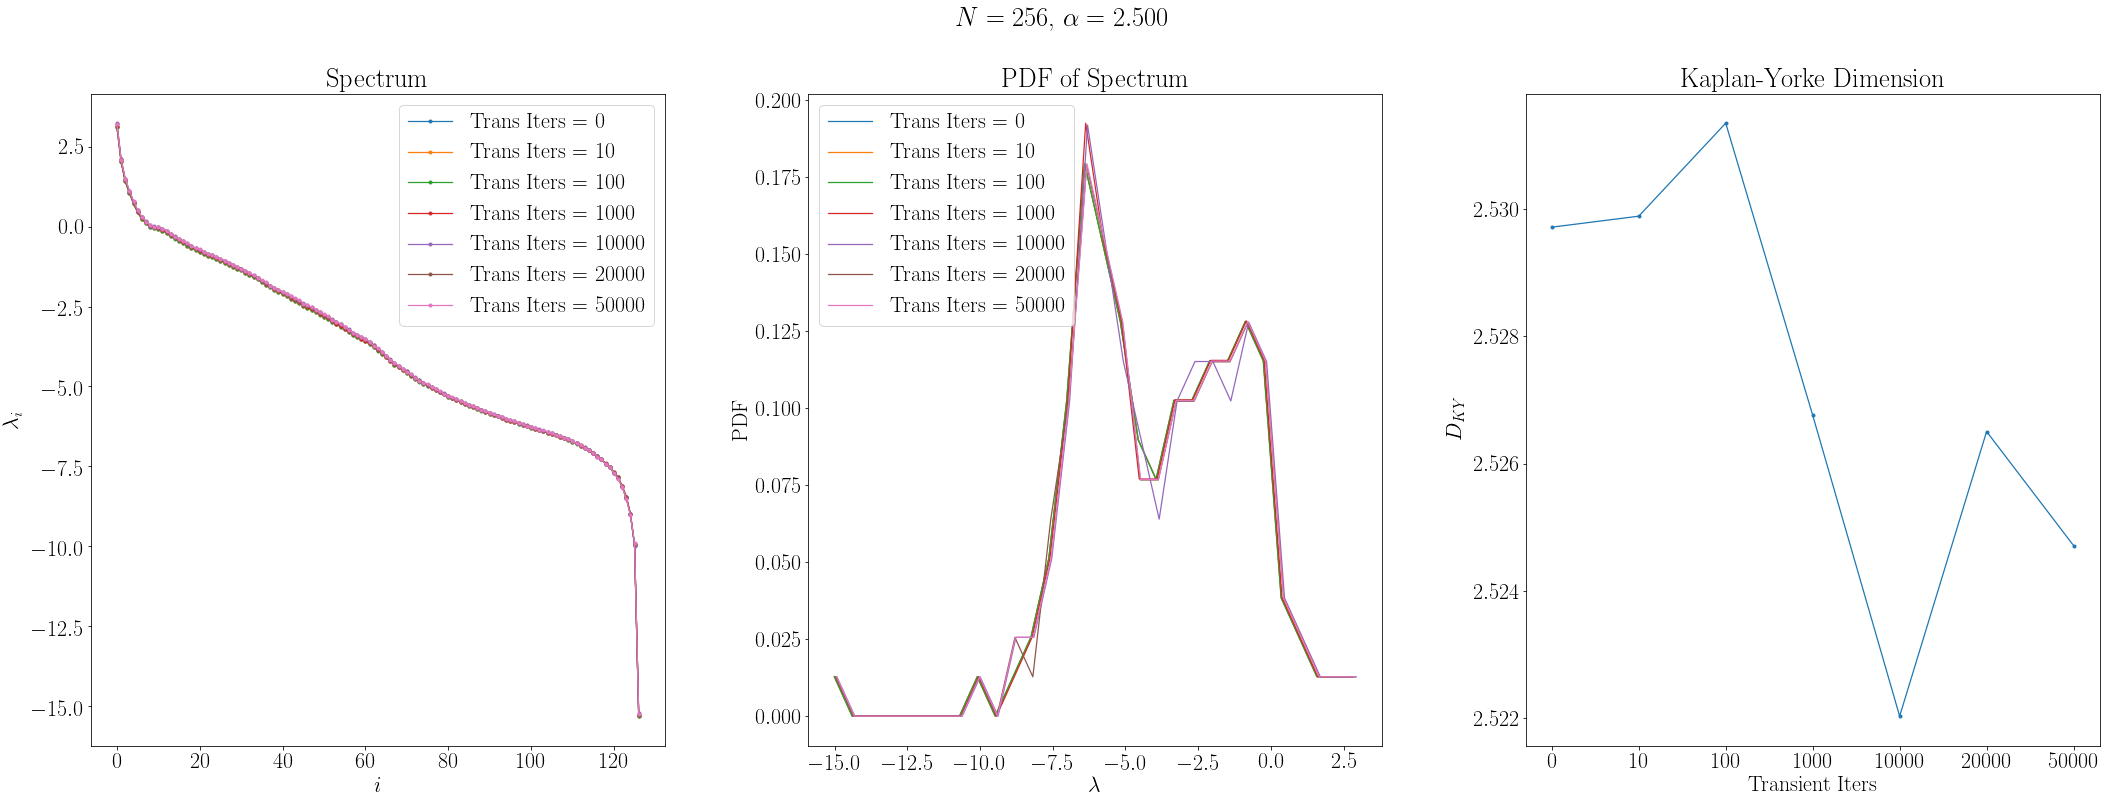

/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


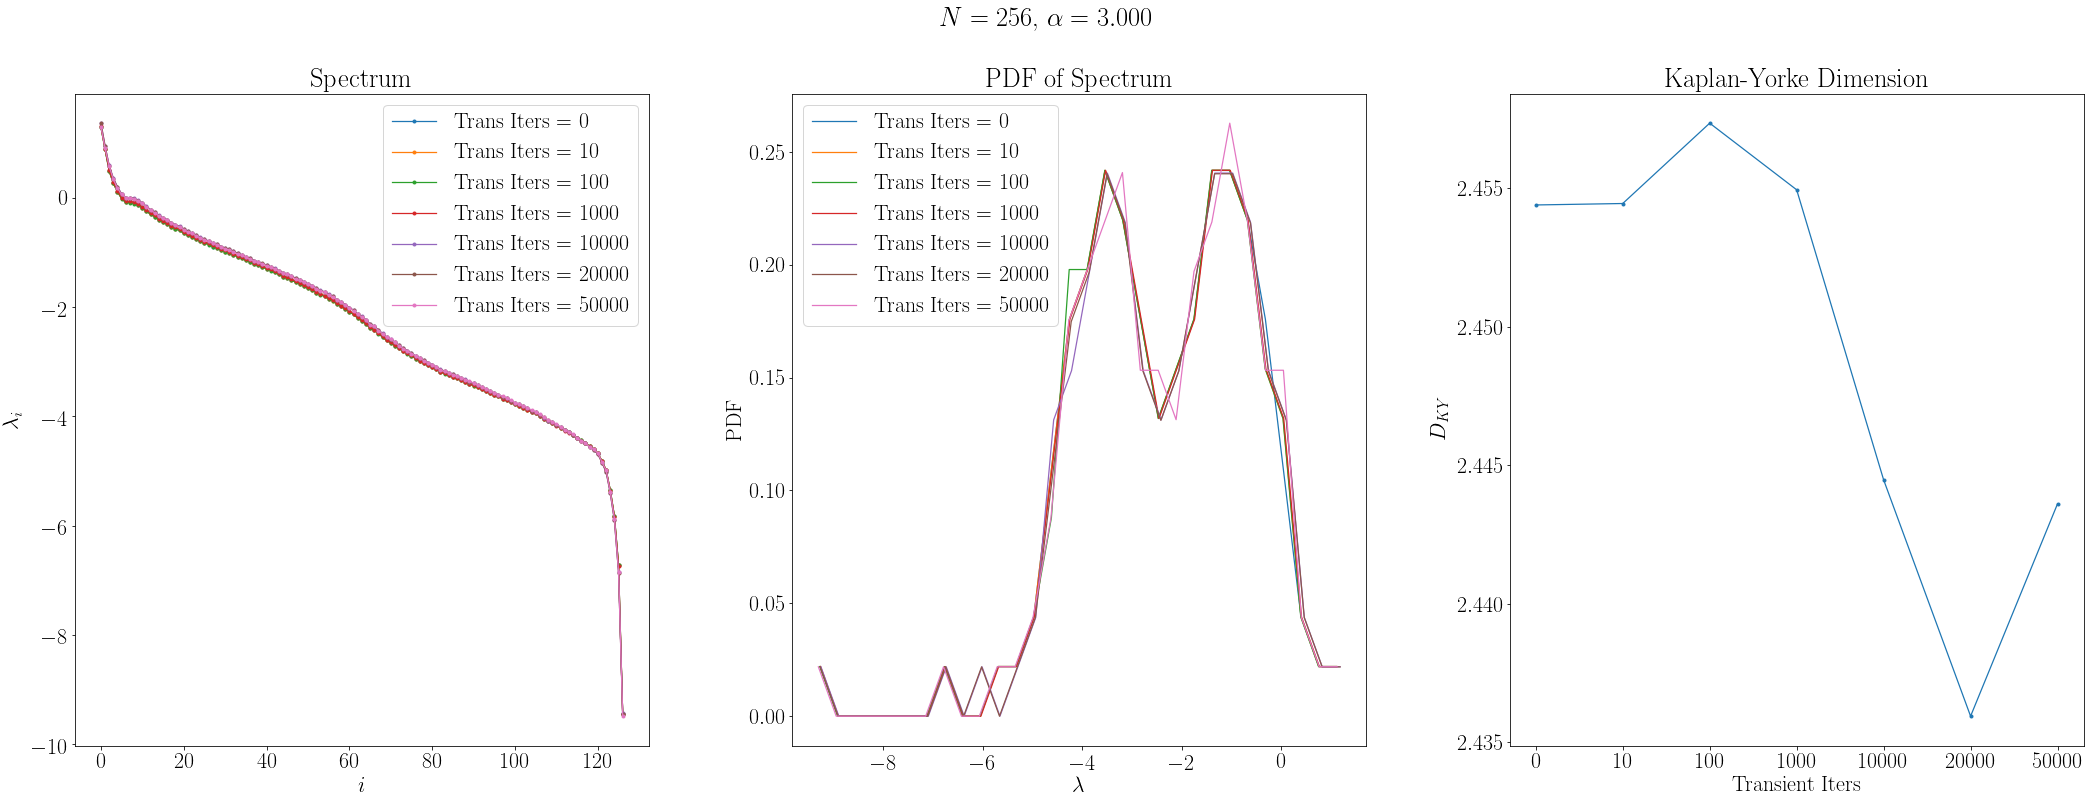

/home/ecarroll/ecpy/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


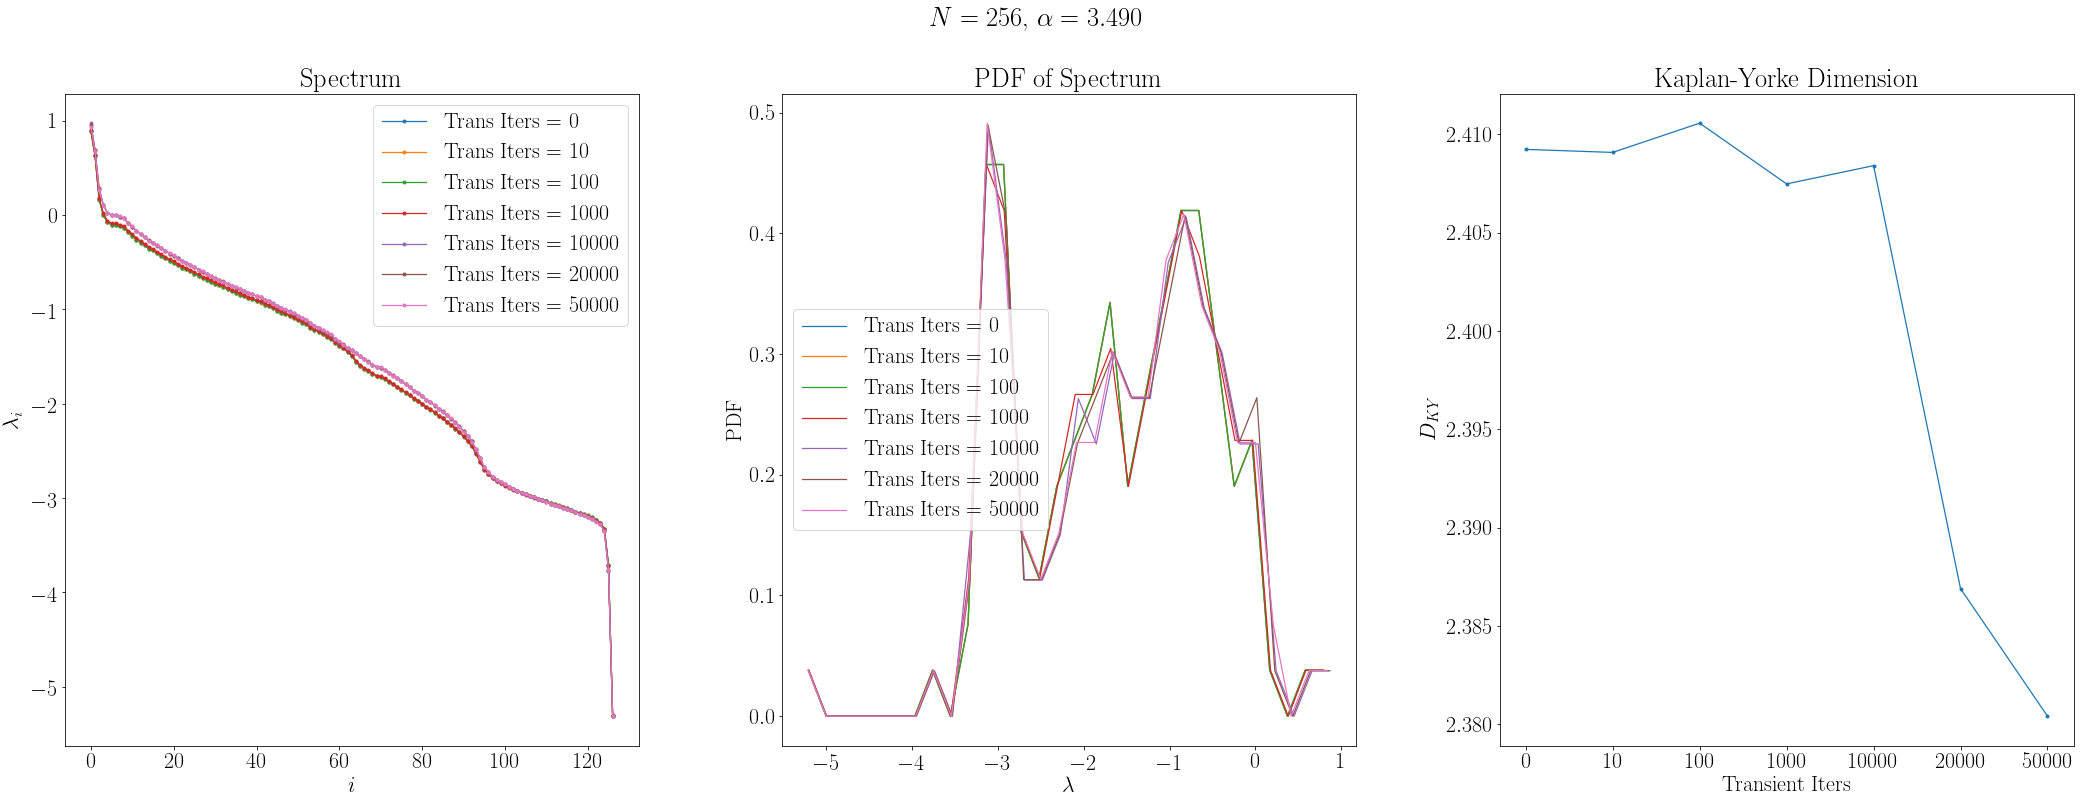

In [168]:
for j, a in enumerate(alpha):
 
    ## Create figure
    fig = plt.figure(figsize = (36, 12), tight_layout = True)
    gs  = GridSpec(1, 3, wspace = 0.25)

    ## Spectrum
    ax1 = fig.add_subplot(gs[0, 0])
    for i, tran in enumerate(trans_iters):
        ax1.plot(lce_py[:, i, j], '.-')
        ax1.set_xlabel(r"$i$")
        ax1.set_ylabel(r"$\lambda_i$")
    ax1.legend([r"Trans Iters = {}".format(t) for t in trans_iters])
    ax1.set_title(r"Spectrum")

    ## PDF
    ax2 = fig.add_subplot(gs[0, 1])
    for i, tran in enumerate(trans_iters):
        hist, bins  = np.histogram(lce_py[:, i, j], bins = int(N / 3), density = True);
        bin_centers = (bins[1:] + bins[:-1]) * 0.5
        ax2.plot(bin_centers, hist)
        ax2.set_xlabel(r"\lambda")
        ax2.set_ylabel(r"PDF")
    ax2.legend([r"Trans Iters = {}".format(t) for t in trans_iters])
    ax2.set_title(r"PDF of Spectrum")

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(dim_py[:, j], '.-')
    ax3.set_xlabel(r"Transient Iters")
    ax3.set_xticks([i for i in range(trans_iters.shape[0])])
    ax3.set_xticklabels([r"${}$".format(t) for t in trans_iters])
    ax3.set_ylabel(r"$D_{KY}$")
    ax3.set_title(r"Kaplan-Yorke Dimension")

    plt.suptitle(r"$N = {}$, $\alpha = {:0.3f}$".format(N, a))
    
    plt.savefig("/work/projects/TurbPhase/burgers_1d_code/Burgers_PO/Data/Snapshots/Test" + "/TransientIters_LCEs_N[{}]_ALPHA[{:0.3f}].pdf".format(N, a)) 
    plt.show()

In [193]:
NN = 256
nn = NN/2
t_0 = 10000
t = 400000 - 2 * t_0
Mem = t * (nn**2 + (nn**2 + nn)/2) + t_0 * (nn**2 + nn)
print(Mem * 8 / 1073741824)

70.99151611328125
